In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lasio
import os
import glob
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from fastdtw import fastdtw
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from geopy.distance import geodesic
import networkx as nx
import scipy.interpolate
import time

In [156]:
# directory on personal computer
ruta = 'C:/Users/User/Desktop/Pan American Energy/reference scripts/initial'
os.chdir(ruta)

ruta_logs = ruta + "/Datos VH_III"
ruta_archivo = ruta_logs +"/Datos VH_III.xlsx"

las_files = glob.glob(os.path.join(ruta_logs, '*.las'))
log_files = glob.glob(os.path.join(ruta_logs, '*.log'))


# Create a directed graph
G = nx.DiGraph()

# get data from excel
well_data = pd.read_excel(ruta_archivo)

def las_to_node(G, filename, col_name):
    node_name = os.path.splitext(os.path.basename(filename))[0]
    las = lasio.read(filename)
    las_df = las.df().dropna()
    las_df = las_df.reset_index()
    new_las = pd.DataFrame(columns=["DEPTH",'RES_DEEP'])
    new_las["DEPTH"] = las_df["DEPTH"]
    new_las["RES_DEEP"] = las_df[col_name]

    coord_data = well_data[well_data["Nombre"]==node_name]
    x_coord = coord_data.iloc[0, 5]
    y_coord = coord_data.iloc[0, 6]

    G.add_node(node_name, data=new_las, pos=(x_coord, y_coord))

    # Add tops
    tops_data = pd.read_excel(ruta_archivo, sheet_name=node_name)
    tops_data = tops_data.drop(index=0)

    a = tops_data[["Capa", "Top"]].copy()
    a.rename(columns={"Top": "Ref"}, inplace=True)

    

    b=tops_data[["Capa", "Base"]].copy()
    b.rename(columns={"Base": "Ref"}, inplace=True)
    resultado = pd.concat([a, b], ignore_index=True)

    tops_vals = resultado.sort_values(by='Ref', ascending=True).reset_index().dropna()

    # print(f"Resultados {node_name}")
    # print(resultado.head(5))
    # print()



    G.nodes[node_name]["known_tops"]=tops_vals.copy()

def log_to_node(G, filename, col_name):
    log_data = []
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    # Identify header and determine the indices of the columns of interest
    header = lines[0].strip().split()
    depth_idx = header.index("DEPTH")
    col_idx = header.index(col_name)

    new_log = pd.DataFrame(columns=["DEPTH",'RES_DEEP'])

    new_log["DEPTH"] = lines[depth_idx]
    new_log["RES_DEEP"] = lines[col_idx]

    print(lines[2])


las_to_node(G, las_files[0], "HT90")
las_to_node(G, las_files[1], "HT90")
las_to_node(G, las_files[2], "HDRS")

#log_to_node(G, log_files[0], "M2R9")




Un grafo ciclico con 3 nodos, esto podria cambiar en el futuro

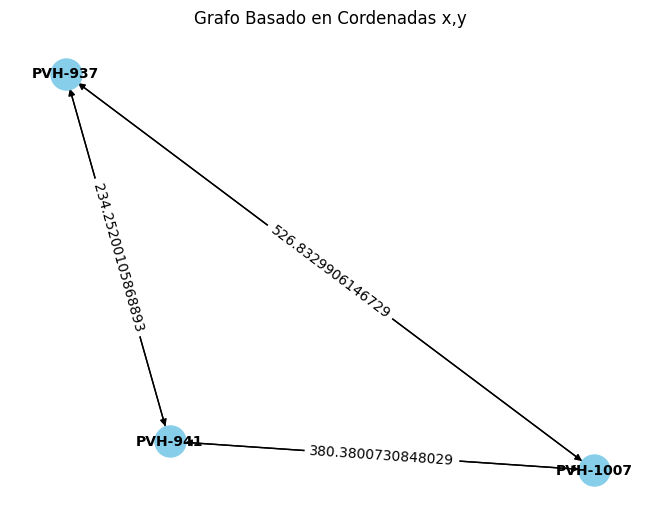

In [157]:
#%%
# Function to calculate geodesic distance between two points
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).meters

def euclidian_distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

threshold_distance = 2000  # Define a distance threshold

for node1, data1 in G.nodes(data=True):
    for node2, data2 in G.nodes(data=True):
        if node1 != node2:
            pos1 = data1['pos']
            pos2 = data2['pos']
            distance = euclidian_distance(pos1[0], pos1[1], pos2[0], pos2[1])
            if distance <= threshold_distance:
                G.add_edge(node1, node2, weight=distance)

# Visualize the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.title("Grafo Basado en Cordenadas x,y")
plt.show()

In [158]:
print(G.nodes["PVH-937"]["data"].head(5))

     DEPTH  RES_DEEP
0  874.575    2.6455
1  874.700    2.5251
2  874.825    2.3703
3  874.950    2.2122
4  875.075    2.1082


Esto es el algoritmo principal. *dtw_calc* hace la computacion principal. *calc_tops* actualiza los datos de tops del siguiente nodo. *profiles_comparison* crea un grafico del dtw path

In [180]:

# helper methods
def normalize_array(arr):
    reshaped_arr = arr.reshape(-1, 1)
    scaler = MinMaxScaler()
    normalized_arr = scaler.fit_transform(reshaped_arr)
    return normalized_arr

def custom_distance(p1, p2):
    return np.abs(p1 - p2) **(1/ 4.3)



# node 1 is the curernt node
# node 2 is the node you attempt to move to
# function gets a dataframe with the predicted depths, assigns to "tops" label in node
def calc_tops(G, node1, node2):

    # create a new dataframe that takes the values of node2 where the "capa" value is the same as in node1
    
    
    correla, df1, df2 = dtw_calc(G, node1, node2)

    
    df_result = pd.DataFrame(columns=["Capa",'Ref'])

    # create a list of j values for unique i values
    j_values_dict = {}

    for i, j in correla:
        
        if i not in j_values_dict:
            j_values_dict[i] = []
        j_values_dict[i].append(j)

    rows_to_add = []
    # obtaining a 1 to 1 relationship between i and j by averaging 
    for i, j_values in j_values_dict.items():
        i_depth = df1["DEPTH"].iloc[i]
        j_depths = [df2["DEPTH"].iloc[j] for j in j_values]
        # averaging j values
        j_depth = np.mean(j_depths) # averaging, may want to try a different method later
        #print(f'i = {i_depth}, j = {j_depths}') print the j values for each corresponding i value
        rows_to_add.append({'Ref': j_depth})

    #capas = G.nodes[node1]["known_tops"]["Capa"]
    
    df_result = pd.concat([df_result, pd.DataFrame(rows_to_add)], ignore_index=True)
    #df_result["Capa"] = capas

    # assign new top values to the node
    G.nodes[node2]["tops"]=df_result
    #print(G.nodes[node2]["tops"])


def dtw_calc(G, node1, node2):
    tolerance = 0.05
    df1 = G.nodes[node1]["data"] # RES_DEEP data for node1
    #tops1 = G.nodes[node1]["known_tops"] # Tops data for node1

    #filter the tops data to only include the tops present in both datasets
    capas1_names = G.nodes["PVH-937"]["known_tops"]["Capa"]  # List of names
    capas2 = G.nodes["PVH-941"]["known_tops"].copy()
    tops1 = capas2[capas2["Capa"].isin(capas1_names)]

    df2 = G.nodes[node2]["data"] # RES_DEEP data for node2



    # mark rows within the tolerance range of any top
    for index_df1, row_df1 in df1.iterrows():
        depth_value = row_df1['DEPTH']
        matches = tops1['Ref'].apply(lambda x: np.abs(x - depth_value) <= tolerance)
        if matches.any():
            df1.at[index_df1, 'Present'] = 1

    G.nodes[node1]["is_top"] = df1[df1['Present'] == 1] # store the filtered rows near the caps into the graph
    prof1 = df1[df1['Present'] == 1]["DEPTH"].reset_index()["DEPTH"][0] - 50
    prof2 = df1[df1['Present'] == 1]["DEPTH"].reset_index()["DEPTH"].iloc[-1] + 50
    df1 = df1[(df1['DEPTH'] > prof1) & (df1['DEPTH'] < prof2)].reset_index()
    df2 = df2[(df2['DEPTH'] > prof1) & (df2['DEPTH'] < prof2)].reset_index()


    # normalize res deep in df1 and df2
    w1 = np.array(df1['RES_DEEP'].dropna())
    w2 = np.array(df2['RES_DEEP'].dropna())
    # might need to use normalized values later, not rn tho
    w1_normalized = normalize_array(w1)
    w2_normalized = normalize_array(w2)


    ref = df1[df1["Present"] == 1]
    distance, path = fastdtw(w1, w2, dist=custom_distance)
    # distance, path = fastdtw(w1_normalized, w2_normalized, dist=custom_distance) Might need to normalize later
    correla = [tupla for tupla in path if tupla[0] in ref.index]

    #mark tops in df2, this block of code is not necessary
    # correla2 = [tupla[1] for tupla in correla]
    # df2["is_top"] = 0
    # for elemento in correla2:
    #     if elemento in df2.index:
    #         df2.loc[elemento, "is_top"] = 1
    # G.nodes[node2]["is_top"] = df2[df2["is_top"] == 1]
    # G.nodes[node2]["Procesados"] = df2
    
    return correla, df1, df2


def profiles_comparison(G, node1, node2, r = None):
    correla, df1, df2 = dtw_calc(G, node1, node2)

    offset = 50
    plt.figure(figsize=(10, 6))

    # Plot df1
    plt.plot(df1["DEPTH"], df1["RES_DEEP"], label=node1, color='blue')

    # Plot df2 with offset
    plt.plot(df2["DEPTH"], df2["RES_DEEP"] + offset, label=node2, color='orange')

    for i, j in correla:
        # Plot the DTW path
        plt.plot([df1["DEPTH"].iloc[i], df2["DEPTH"].iloc[j]], [df1["RES_DEEP"].iloc[i], df2["RES_DEEP"].iloc[j] + offset], color='red', linestyle='-')

    plt.title(node2 + " " + node1)
    plt.xlabel('Depth (m)')
    if r:
        plt.xlim(1610, 1640)
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()


Aqui se corre el algoritmo, calculando los topes de 1499 usando los datos de 1318

In [181]:
calc_tops(G, "PVH-937", "PVH-941")


i = 978.7, j = [953.125]
i = 985.075, j = [954.625]
i = 991.075, j = [960.25]
i = 996.325, j = [961.125]
i = 1016.95, j = [964.875]
i = 1018.325, j = [965.375]
i = 1025.95, j = [965.75]
i = 1029.2, j = [968.625]
i = 1036.45, j = [972.25]
i = 1041.95, j = [977.75]
i = 1044.825, j = [979.25]
i = 1091.825, j = [989.0]
i = 1102.325, j = [990.25]
i = 1109.2, j = [997.125]
i = 1149.575, j = [1015.75]
i = 1150.325, j = [1016.25]
i = 1155.075, j = [1017.0]
i = 1156.45, j = [1017.0]
i = 1162.45, j = [1018.125]
i = 1162.7, j = [1018.375]
i = 1170.075, j = [1024.875]
i = 1170.7, j = [1025.375]
i = 1203.325, j = [1037.875]
i = 1204.325, j = [1037.875]
i = 1211.575, j = [1044.75]
i = 1212.95, j = [1046.125]
i = 1218.7, j = [1048.875]
i = 1219.325, j = [1048.875]
i = 1222.825, j = [1048.875]
i = 1223.45, j = [1048.875]
i = 1232.95, j = [1053.0]
i = 1233.45, j = [1053.0]
i = 1236.95, j = [1054.75]
i = 1250.325, j = [1058.75]
i = 1250.95, j = [1058.75]
i = 1255.075, j = [1061.625]
i = 1257.325, j = [1

C:\Users\User\AppData\Local\Temp\ipykernel_29744\3864211044.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, pd.DataFrame(rows_to_add)], ignore_index=True)


In [177]:
print(G.nodes["PVH-941"]["tops"])

    Capa       Ref
0    NaN   953.125
1    NaN   954.625
2    NaN   960.250
3    NaN   961.125
4    NaN   964.875
..   ...       ...
110  NaN  1586.375
111  NaN  1597.625
112  NaN  1601.750
113  NaN  1606.125
114  NaN  1607.875

[115 rows x 2 columns]


In [163]:
print(G.nodes["PVH-937"]["known_tops"])

    index Capa     Ref
0       7   C4   973.9
1     109   C4   978.7
2       8   C5   985.1
3     110   C5   991.1
4       9  C5A   996.3
..    ...  ...     ...
73    181   R4  1909.9
74     80   R5  1931.6
75    182   R5  1935.8
76     81  R5a  1938.3
77    183  R5a  1941.9

[78 rows x 3 columns]


In [152]:
capas1 = G.nodes["PVH-937"]["known_tops"].copy()
capas2 = G.nodes["PVH-941"]["known_tops"].copy()

# Set "Capa" as the index for both DataFrames
capas1_indexed = capas1.set_index("Capa")
capas2_indexed = capas2.set_index("Capa")

# Join the DataFrames based on the "Capa" index
joined_df = capas1_indexed.join(capas2_indexed, lsuffix='_1', rsuffix='_2', how="inner")

# Filter the rows where the "Capa" column is equal
b = joined_df[joined_df.index.isin(capas1["Capa"])]
b.reset_index(inplace=True)
new_df2 = b[["Capa", "Ref_2"]]
new_df2.drop_duplicates(inplace=True) # could lead to issues in the future, works for now, need to find a way to directly join rather than delete duplicates

print(new_df2)


   Capa    Ref_2
0    C7   1018.3
1    C7     1026
4    C9   1036.5
5    C9   1044.8
8    K1   1091.8
9    K1   1109.2
12  K10   1233.4
13  K10   1236.9
16  K14   1250.3
17  K14   1257.3
20  K17   1270.4
21  K17   1274.6
24   K3   1150.3
25   K3   1156.4
28   K4   1162.7
29   K4   1170.7
32   K8   1204.3
33   K8   1212.9
36   K9   1219.3
37   K9   1223.5
40   L3   1279.2
41   L3   1287.1
44   L4     1298
45   L4   1303.4
48   M1   1397.1
49   M1   1400.9
52  M11   1528.1
53  M11   1531.6
56   M6  1438.38
57   M6  1440.64
60  M6A     1452
61  M6A   1460.6
64  M8a  1488.36
65  M8a  1491.21
68  M8b   1495.2
69  M8b   1499.3
72   O4   1575.3
73   O4   1584.6
76   O5   1589.4
77   O5   1593.9
80  O5a     1598
81  O5a   1601.9
84  O5b   1605.4
85  O5b   1609.2


C:\Users\User\AppData\Local\Temp\ipykernel_29744\3675556994.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df2.drop_duplicates(inplace=True) # could lead to issues in the future, works for now, need to find a way to directly join rather than delete duplicates


Como los valores de 1499 son conocidos, usamos esos datos para evaluar el algoritmo

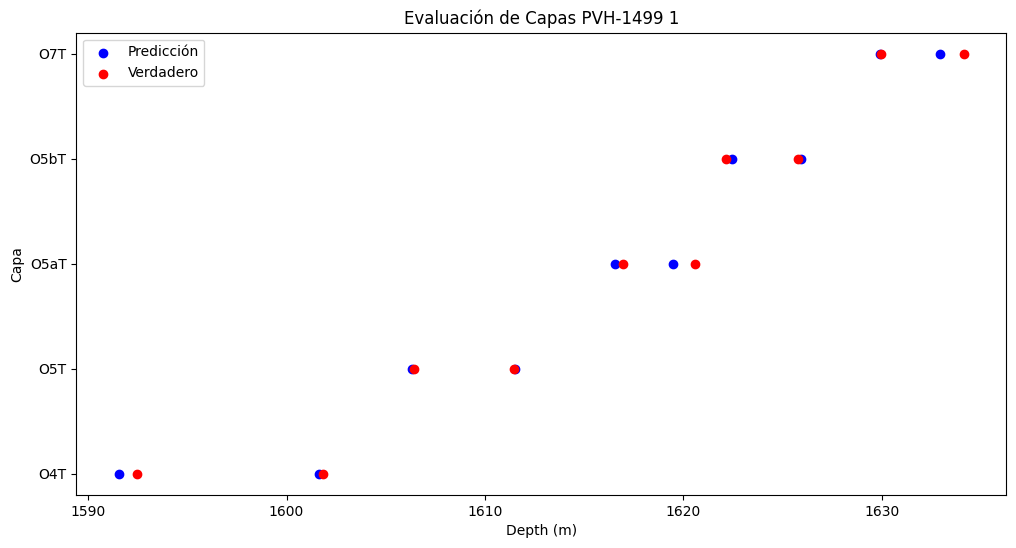

In [139]:
df_topes = G.nodes["PVH-1499 1"]["tops"]

plt.figure(figsize=(12, 6))
plt.scatter(df_topes['Ref'], df_topes['Capa'], color='blue', label='Predicción')
plt.scatter(vtops['Ref'], vtops['Capa'], color='red', label='Verdadero')

plt.xlabel('Depth (m)')
plt.ylabel('Capa')
plt.title('Evaluación de Capas PVH-1499 1')
plt.legend()
plt.show()

Mas analisis

  Capa_x   Ref_pred   Ref_true      Pozo Capa_y
0    O4T  1591.5332  1592.4712  PVH-1499    O4T
1    O4T  1601.6332  1601.8442  PVH-1499    O4T
2    O5T  1606.3332  1606.4203  PVH-1499    O5T
3    O5T  1611.5332  1611.4777  PVH-1499    O5T
4   O5aT  1616.5332  1616.9452  PVH-1499   O5aT
5   O5aT  1619.4832  1620.5903  PVH-1499   O5aT
6   O5bT  1622.4332  1622.1523  PVH-1499   O5bT
7   O5bT  1625.9332  1625.8013  PVH-1499   O5bT
8    O7T  1629.9332  1629.9545  PVH-1499    O7T
9    O7T  1632.9332  1634.1488  PVH-1499    O7T


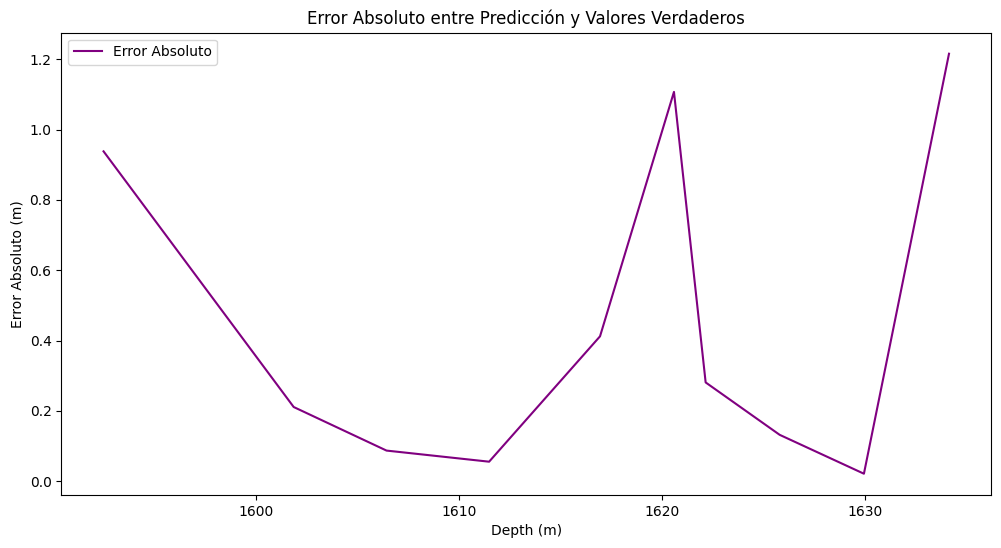

In [140]:
# Calcular la diferencia absoluta entre las predicciones y los valores verdaderos
vtops_sorted = vtops.sort_values(by='Ref', ascending=True).reset_index() # sort to get the depths in order

df_merged = pd.merge_asof(df_topes.sort_values('Ref'), vtops.sort_values('Ref'), on='Ref', direction='nearest')
df_merged.rename(columns={"Ref": "Ref_pred"}, inplace=True)
df_merged.insert(2, "Ref_true", vtops_sorted['Ref'])
print(df_merged)


df_merged['Error_Absoluto'] = np.abs(df_merged['Ref_pred'] - df_merged['Ref_true'])
df_merged['Error_Porcentual'] = df_merged['Error_Absoluto'] / df_merged['Ref_true'] * 100

# Resumen estadístico
estadisticas = df_merged[['Error_Absoluto', 'Error_Porcentual']].describe()


# Gráfico de errores absolutos
plt.figure(figsize=(12, 6))
plt.plot(df_merged['Ref_true'], df_merged['Error_Absoluto'], label='Error Absoluto', color='purple')
plt.xlabel('Depth (m)')
plt.ylabel('Error Absoluto (m)')
plt.title('Error Absoluto entre Predicción y Valores Verdaderos')
plt.legend()
plt.show()


Ahora se tiene que evaluar el algoritmo en un grafo ciclico con 3 nodos. En teoria los valores de 1318 al final del ciclo deberian ser iguales a los valores originales

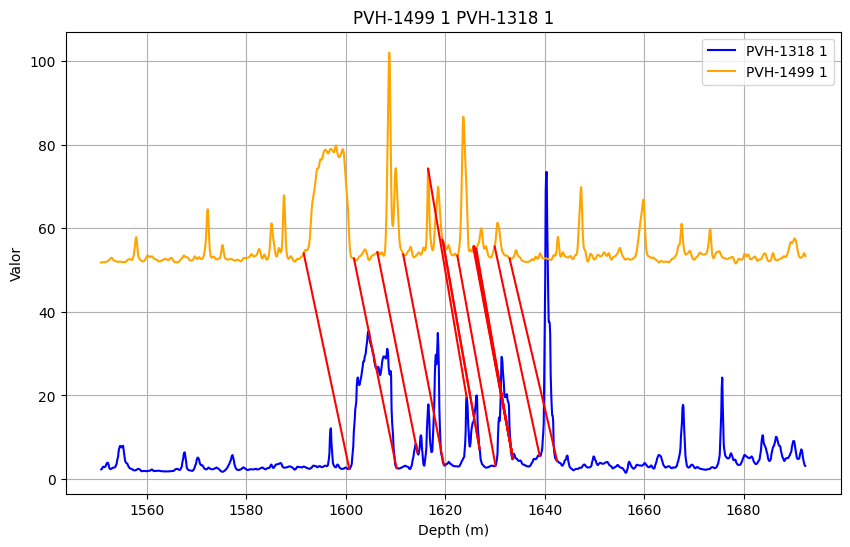

C:\Users\User\AppData\Local\Temp\ipykernel_16128\3895257676.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, pd.DataFrame(rows_to_add)], ignore_index=True)


   Capa        Ref
0   O4T  1591.5332
1   O4T  1601.6332
2   O5T  1606.3332
3   O5T  1611.5332
4  O5aT  1616.5332
5  O5aT  1619.4832
6  O5bT  1622.4332
7  O5bT  1625.9332
8   O7T  1629.9332
9   O7T  1632.9332


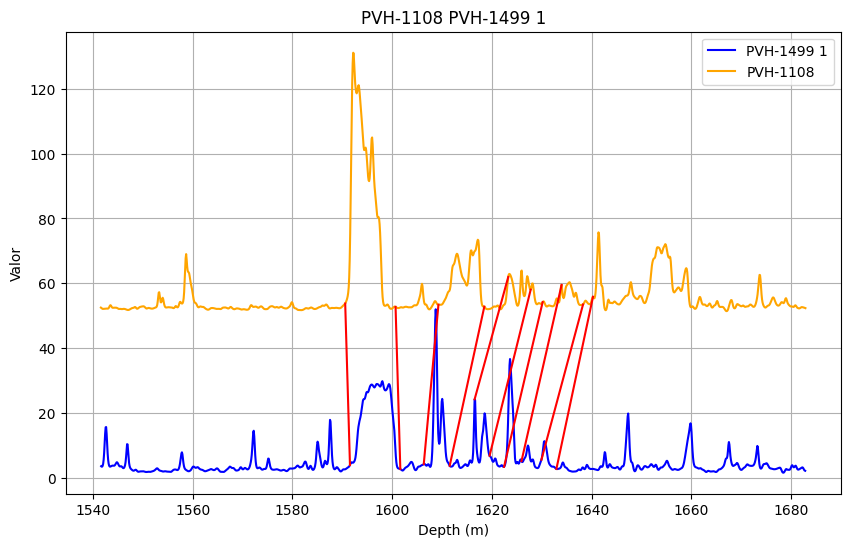

C:\Users\User\AppData\Local\Temp\ipykernel_16128\3895257676.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, pd.DataFrame(rows_to_add)], ignore_index=True)


   Capa        Ref
0   O4T  1590.5776
1   O4T  1600.6776
2   O5T  1609.2776
3   O5T  1618.4776
4  O5aT  1623.2776
5  O5aT  1627.7776
6  O5bT  1630.1776
7  O5bT  1633.9776
8   O7T  1638.2776
9   O7T  1640.2776


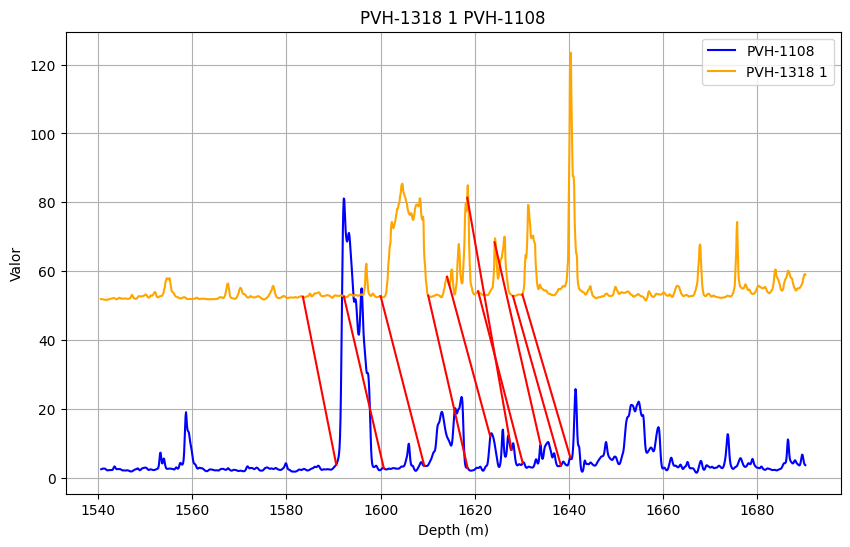

   Capa     Ref
0   O4T  1583.5
1   O4T  1592.2
2   O5T  1600.0
3   O5T  1610.1
4  O5aT  1614.1
5  O5aT  1618.4
6  O5bT  1620.7
7  O5bT  1624.2
8   O7T  1628.1
9   O7T  1630.1


C:\Users\User\AppData\Local\Temp\ipykernel_16128\3895257676.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, pd.DataFrame(rows_to_add)], ignore_index=True)


In [141]:
# go from 1318 1 to 1108 to 1499 1 back to 1318 1

profiles_comparison(G, "PVH-1318 1", "PVH-1499 1")
calc_tops(G, "PVH-1318 1", "PVH-1499 1")

profiles_comparison(G, "PVH-1499 1", "PVH-1108")
calc_tops(G, "PVH-1499 1", "PVH-1108")

profiles_comparison(G, "PVH-1108", "PVH-1318 1")
calc_tops(G, "PVH-1108", "PVH-1318 1")



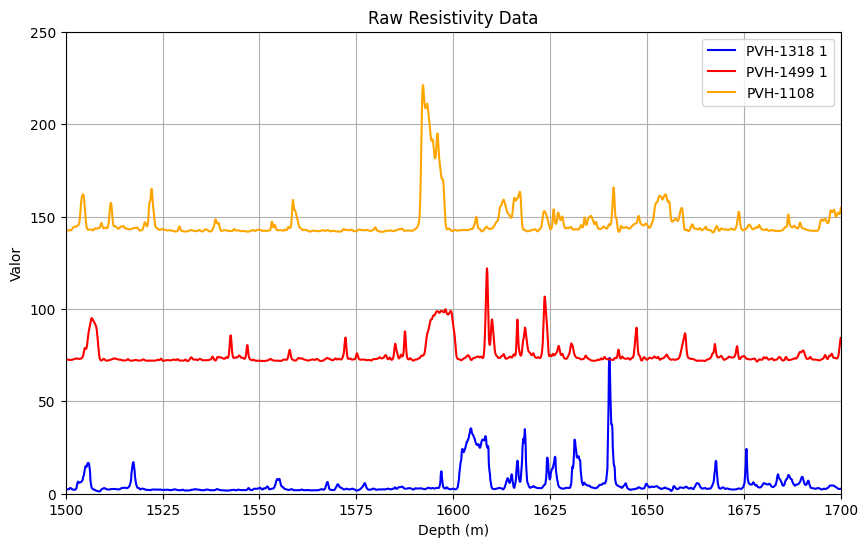

In [142]:

offset = 70
graph1 = G.nodes["PVH-1318 1"]["data"]
graph2 = G.nodes["PVH-1499 1"]["data"]
graph3 = G.nodes["PVH-1108"]["data"]
plt.figure(figsize=(10, 6))

    # Plot df1
plt.plot(graph1["DEPTH"], graph1["RES_DEEP"], label="PVH-1318 1", color='blue')

    # Plot df2 with offset
plt.plot(graph2["DEPTH"], graph2["RES_DEEP"] + offset, label="PVH-1499 1", color='red')
plt.plot(graph3["DEPTH"], graph3["RES_DEEP"] + offset*2, label="PVH-1108", color='orange')

plt.title("Raw Resistivity Data")
plt.xlabel('Depth (m)')
plt.xlim(1500, 1700)
plt.ylabel('Valor')
plt.ylim(0,250)
plt.legend()
plt.grid(True)
plt.show()

Comparar los datos originales con los calculados

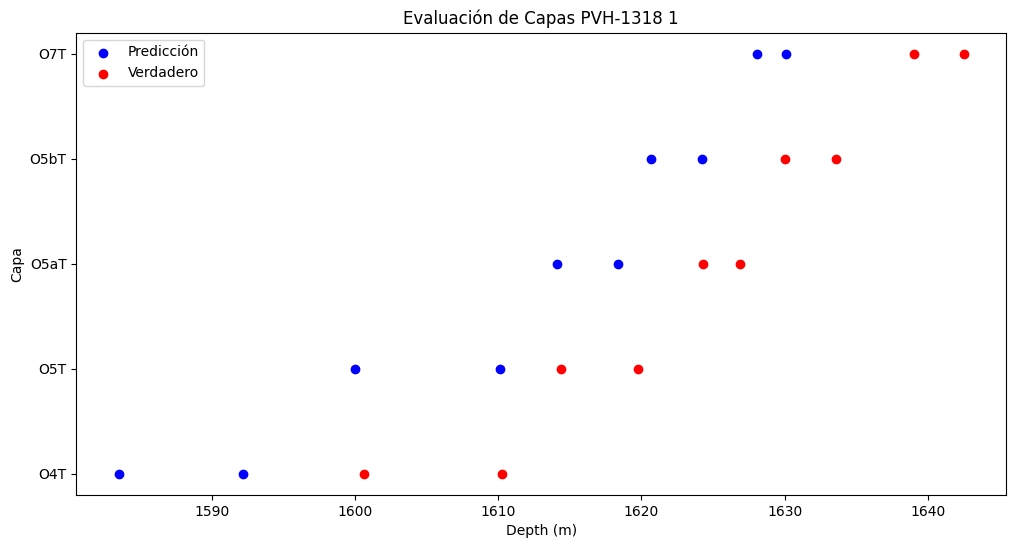

In [143]:
nuevo = pd.DataFrame()
nuevo = G.nodes["PVH-1318 1"]["tops"]

# Resultados
plt.figure(figsize=(12, 6))
plt.scatter(nuevo['Ref'], nuevo['Capa'], color='blue', label='Predicción')
plt.scatter(tops['Ref'], tops['Capa'], color='red', label='Verdadero')

plt.xlabel('Depth (m)')
plt.ylabel('Capa')
plt.title('Evaluación de Capas PVH-1318 1')
plt.legend()
plt.show()

Display the nodes on the graph side by side

In [144]:
depth_range = [1500, 1700]
g1 = tops
g2 = G.nodes["PVH-1499 1"]["tops"]
g3 = G.nodes["PVH-1108"]["tops"]
g1_prime = G.nodes["PVH-1318 1"]["tops"]

logs_depths = [g1, g2, g3, g1_prime]

data1 = G.nodes["PVH-1318 1"]["data"]
data2 = G.nodes["PVH-1499 1"]["data"]
data3 = G.nodes["PVH-1108"]["data"]

data_logs = [data1, data2, data3, data1]

# Modified from Wheeler Hale notebook
def plot_logs(logs, vfield, yfield=None, title=None, depth_range=None):
    n_logs = len(logs)
    fig, ax = plt.subplots(nrows=1, ncols=n_logs, figsize=(12, 9), sharey=True)
    
    if title:
        plt.suptitle(title)
    if yfield:
        miny, maxy = depth_range if depth_range else (np.inf, -np.inf)
        for log in logs:
            if depth_range:
                log = log[(log[yfield] >= depth_range[0]) & (log[yfield] <= depth_range[1])]
            if log[yfield].min() < miny:
                miny = log[yfield].min()
            if log[yfield].max() > maxy:
                maxy = log[yfield].max()
        ax[0].set_ylabel(yfield)
    else:
        miny, maxy = depth_range if depth_range else (np.inf, -np.inf)
        for log in logs:
            if depth_range:
                log = log[(log.index >= depth_range[0]) & (log.index <= depth_range[1])]
            if log.index.min() < miny:
                miny = log.index.min()
            if log.index.max() > maxy:
                maxy = log.index.max()
        ax[0].set_ylabel('Depth')

    for log_idx, log in enumerate(logs):
        if yfield:
            y_vals = log[yfield]
        else:
            y_vals = log.index.values
        
        if depth_range:
            y_vals = y_vals[(y_vals >= depth_range[0]) & (y_vals <= depth_range[1])]
            log = log[(log[yfield] >= depth_range[0]) & (log[yfield] <= depth_range[1])]
        
        log_interp = scipy.interpolate.interp1d(y_vals, log[vfield], bounds_error=False)
        fnew = np.linspace(miny, maxy, int(maxy - miny + 1))
        ynew = log_interp(fnew)
        ynew = ynew[:, np.newaxis]
        vmin = np.nanpercentile(ynew, 3)
        vmax = np.nanpercentile(ynew, 97)
        ax[log_idx].set_xticks([])
        ax[log_idx].set_yticks([])
        ax[log_idx].grid(False)
        ax[log_idx].imshow(ynew, aspect='auto', vmin=vmin, vmax=vmax)
        
        # Highlighting the 'Ref' depths
        # if 'Ref' in logs_depths[log_idx].columns:
        #     ref_depths = logs_depths[log_idx]['Ref']
        #     ref_depths = ref_depths[(ref_depths >= depth_range[0]) & (ref_depths <= depth_range[1])]
        #     for ref_depth in ref_depths:
        #         # Add scatter point
        #         ax[log_idx].scatter([0], ref_depth, color='red', s=10)  # Adjust 's' for marker size
        #         # Add a vertical line
        #         ax[log_idx].axhline(y=ref_depth, color='yellow', linestyle='--', linewidth=0.5)


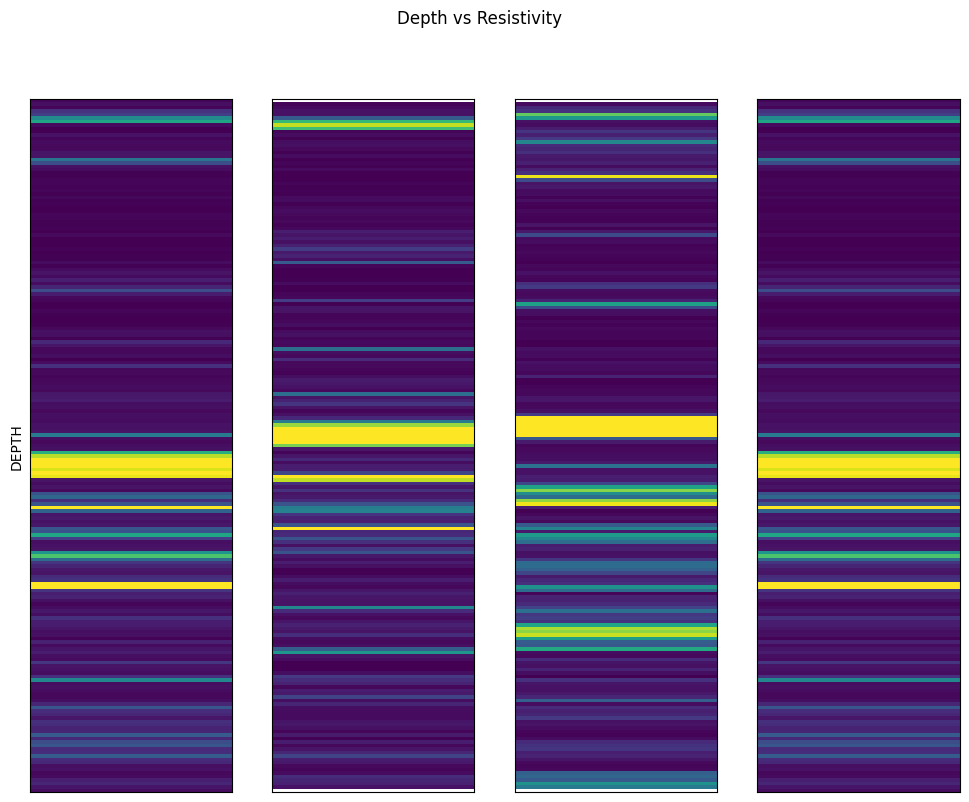

In [145]:
plot_logs(data_logs, 'RES_DEEP', yfield='DEPTH', title='Depth vs Resistivity', depth_range=depth_range)


Graph the predicted log values for each capa for each of the nodes in the graph cycle

In [146]:
# Insert all prediction results into a dataframe
tops_sorted = tops.sort_values(by='Ref', ascending=True).reset_index() # sort to get the depths in order
all_pred = tops_sorted

all_pred.insert(3, "pred2", g2["Ref"])
all_pred.insert(4, "pred3", g3["Ref"])
all_pred.insert(5, "pred1*", g1_prime["Ref"])


print(all_pred)

   index      Pozo  Capa      pred2      pred3  pred1*        Ref
0      0  PVH-1318   O4T  1591.5332  1590.5776  1583.5  1600.6632
1      5  PVH-1318   O4T  1601.6332  1600.6776  1592.2  1610.2498
2      1  PVH-1318   O5T  1606.3332  1609.2776  1600.0  1614.4039
3      6  PVH-1318   O5T  1611.5332  1618.4776  1610.1  1619.7299
4      2  PVH-1318  O5aT  1616.5332  1623.2776  1614.1  1624.3099
5      7  PVH-1318  O5aT  1619.4832  1627.7776  1618.4  1626.8663
6      3  PVH-1318  O5bT  1622.4332  1630.1776  1620.7  1630.0619
7      8  PVH-1318  O5bT  1625.9332  1633.9776  1624.2  1633.5769
8      4  PVH-1318   O7T  1629.9332  1638.2776  1628.1  1639.0092
9      9  PVH-1318   O7T  1632.9332  1640.2776  1630.1  1642.5242


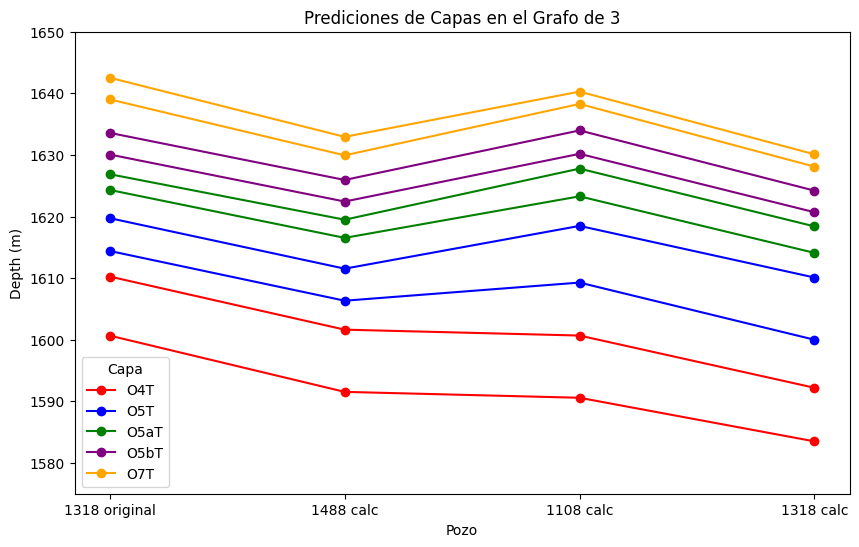

In [147]:
# Graph Dataframe
# Create a plot
fig, ax = plt.subplots(figsize=(10, 6))

# Unique colors for each 'Capa'
colors = {
    'O4T': 'red',
    'O5T': 'blue',
    'O5aT': 'green',
    'O5bT': 'purple',
    'O7T': 'orange'
}

# Iterate over each row in the dataframe
for _, row in all_pred.iterrows():
    x_values = ['1318 original', '1488 calc', '1108 calc', '1318 calc']
    y_values = [row['Ref'], row['pred2'], row['pred3'], row['pred1*']]
    
    # Get the corresponding color for the 'Capa'
    color = colors[row['Capa']]
    
    # Plot the line
    ax.plot(x_values, y_values, marker='o', color=color, label=row['Capa'] if row['Capa'] not in ax.get_legend_handles_labels()[1] else "")
    ax.set_ylim([1575, 1650])

# Set labels and title
ax.set_xlabel('Pozo')
ax.set_ylabel('Depth (m)')
ax.set_title('Prediciones de Capas en el Grafo de 3')

# Add legend
ax.legend(title='Capa')

# Display the plot
plt.show()

Attempt to change tolerance parameter to see if it improves error. Can also modify the distance calculation, maybe compare to Ln normalizations, can also modify "window" size. Also, see how the Wheeler Hale paper adresses these issues

In [148]:
tolerance = 0.1